# Hybrid Model

In [1]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

We do not specify the AR and MA orders in `auto_arima` library in the sense that `start_p`, `start_q` and other parameters require initial order. Using this initial order, library find the optimum one.

In [2]:
# This code imports the data you generated before for replicating.
stock_prices = pd.read_csv('stock_prices.csv')
arima_predictions_T = pd.read_csv('arima_predictions_T')
arima_predictions_VZ = pd.read_csv('arima_predictions_VZ')

split = int(len(stock_prices['VZ'])*0.95)
train_T = stock_prices['T'].iloc[:split]
test_T = stock_prices['T'].iloc[split:]
train_VZ = stock_prices['VZ'].iloc[:split]
test_VZ = stock_prices['VZ'].iloc[split:]

diff_T = stock_prices['T'].diff().dropna()
diff_VZ = stock_prices['VZ'].diff().dropna()
split = int(len(diff_T.values)*0.95)
diff_train_T = diff_T.iloc[:split]
diff_test_T = diff_T.iloc[split:]
diff_train_VZ = diff_VZ.iloc[:split]
diff_test_VZ = diff_VZ.iloc[split:]

## AT&T

In [3]:
auto_arima_T = auto_arima(train_T, start_p=1, start_q=1, d=1, \
               max_p=15, max_q=15, information_criterion="bic")
prediction_arima_T = list(auto_arima_T.predict_in_sample())
residual_T = pd.Series(np.array(train_T) - np.array(prediction_arima_T))

In [4]:
residual_T.to_csv('residual_T.csv')
pd.DataFrame(prediction_arima_T).to_csv('prediction_arima_T.csv')

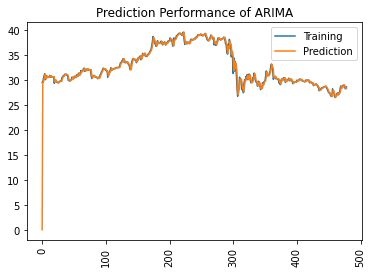

In [5]:
plt.plot(train_T.index, train_T, label='Training')
plt.plot(train_T.index, prediction_arima_T, label='Prediction')
plt.title('Prediction Performance of ARIMA')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

## Verizon

In [6]:
auto_arima_VZ = auto_arima(train_VZ, start_p=1, start_q=1, d=1, \
               max_p=15, max_q=15, information_criterion="bic")
prediction_arima_VZ = list(auto_arima_VZ.predict_in_sample())
residual_VZ = pd.Series(np.array(train_VZ)- np.array(prediction_arima_VZ))



In [7]:
residual_VZ.to_csv('residual_VZ.csv')
pd.DataFrame(prediction_arima_VZ).to_csv('prediction_arima_VZ.csv')

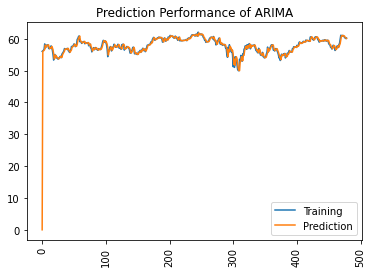

In [8]:
plt.plot(train_VZ.index, train_VZ, label='Training')
plt.plot(train_VZ.index, prediction_arima_VZ, label='Prediction')
plt.title('Prediction Performance of ARIMA')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

## AT&T

In [9]:
train_extended_T = np.array(diff_train_T) + np.array(residual_T[1:])

In [10]:
n_steps = 10
n_features = 1

In [11]:
# This code is imported from the previous milestone for replicating.

def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



In [12]:
X_train_res_T, y_train_res_T = split_sequence(train_extended_T, n_steps)
X_train_res_T = X_train_res_T.reshape((X_train_res_T.shape[0],  X_train_res_T.shape[1], n_features))
X_test_res_T, y_test_res_T = split_sequence(diff_test_T.values, n_steps)
X_test_res_T = X_test_res_T.reshape((X_test_res_T.shape[0],  X_test_res_T.shape[1], n_features))

In [13]:
model = Sequential()
model.add(LSTM(128, activation='relu',
          input_shape=(n_steps, n_features),
          return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(optimizer = 'adam' , loss='mean_squared_error',metrics=['mse'])

In [14]:
history = model.fit(X_train_res_T, y_train_res_T, batch_size= 200,
                    epochs=200,verbose=0)

In [15]:
start = X_test_res_T[X_test_res_T.shape[0]-1]
T_input = start
T_input = T_input.reshape((1, n_steps, n_features))

In [16]:
DL_predictions_T = []

for i in range(len(arima_predictions_T)):
    T_input = T_input.reshape((1, n_steps, n_features))
    yhat_lstm = model.predict(T_input, verbose=0)
    T_input = np.append(T_input, yhat_lstm)
    T_input = T_input[1:]
    DL_predictions_T.append(yhat_lstm)

In [17]:
predict_arima_res = pd.DataFrame(prediction_arima_T)[ - (1 + len(arima_predictions_T)):].reset_index()
del predict_arima_res['index']

In [18]:
hybrid_prediction = pd.DataFrame(np.array(DL_predictions_T).flatten()) + predict_arima_res.diff()[1:].reset_index()
del hybrid_prediction['index']

In [19]:
df_train_extended_T = pd.DataFrame(train_extended_T)
df_train_extended_T.index = diff_train_T.index

In [20]:
df_diff_test_T = pd.DataFrame(diff_test_T)
df_diff_test_T.index = pd.to_datetime(df_diff_test_T.index)

In [21]:
hybrid_prediction.set_index(df_diff_test_T[ - len(arima_predictions_T):].index, inplace=True)

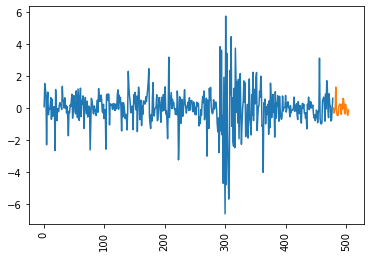

In [22]:
plt.plot(df_train_extended_T.index, df_train_extended_T.values)
plt.plot(diff_test_T[ - len(hybrid_prediction):].index, np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

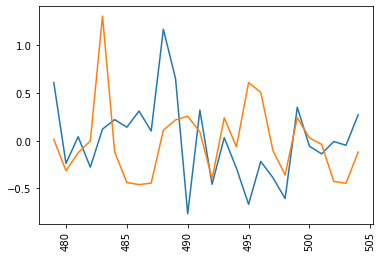

In [23]:
plt.plot(diff_test_T[ - len(hybrid_prediction):].index,
         diff_test_T[ - len(hybrid_prediction):])
plt.plot(diff_test_T[ - len(hybrid_prediction):].index,
         np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

In [24]:
def rmse(y,yhat):
    return np.sqrt(mean_squared_error(y,yhat))

In [25]:
hybrid_rmse = rmse(np.array(diff_test_T[ - len(hybrid_prediction):].values),
                   hybrid_prediction)
print('Hybrid RMSE is {:.4f}'.format(hybrid_rmse))

Hybrid RMSE is 0.5742


## Verizon

In [26]:
train_extended_VZ = np.array(diff_train_VZ) + np.array(residual_VZ[1:])

In [27]:
X_train_res_VZ, y_train_res_VZ = split_sequence(train_extended_VZ, n_steps)
X_train_res_VZ = X_train_res_VZ.reshape((X_train_res_VZ.shape[0],  X_train_res_VZ.shape[1], n_features))
X_test_res_VZ, y_test_res_VZ = split_sequence(diff_test_VZ.values, n_steps)
X_test_res_VZ = X_test_res_VZ.reshape((X_test_res_VZ.shape[0],  X_test_res_VZ.shape[1], n_features))

In [28]:
model = Sequential()
model.add(LSTM(128, activation='relu',
          input_shape=(n_steps, n_features),
          return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(optimizer = 'adam' , loss='mean_squared_error',metrics=['mse'])

In [29]:
history = model.fit(X_train_res_VZ, y_train_res_VZ, batch_size= 200,
                    epochs=200,verbose=0)

In [30]:
start = X_test_res_VZ[X_test_res_VZ.shape[0]-1]
VZ_input = start
VZ_input = VZ_input.reshape((1, n_steps, n_features))

In [31]:
DL_predictions_VZ = []

for i in range(len(arima_predictions_VZ)):
    VZ_input = VZ_input.reshape((1, n_steps, n_features))
    yhat_lstm = model.predict(VZ_input, verbose=0)
    VZ_input = np.append(VZ_input, yhat_lstm)
    VZ_input = VZ_input[1:]
    DL_predictions_VZ.append(yhat_lstm)

In [32]:
predict_arima_res = pd.DataFrame(prediction_arima_VZ)[ - (1 + len(arima_predictions_VZ)):].reset_index()
del predict_arima_res['index']

In [33]:
hybrid_prediction = pd.DataFrame(np.array(DL_predictions_VZ).flatten()) + predict_arima_res.diff()[1:].reset_index()
del hybrid_prediction['index']

In [34]:
df_train_extended_VZ = pd.DataFrame(train_extended_VZ)
df_train_extended_VZ.index = diff_train_VZ.index

In [35]:
df_diff_test_VZ = pd.DataFrame(diff_test_VZ)
df_diff_test_VZ.index = pd.to_datetime(df_diff_test_VZ.index)

In [36]:
hybrid_prediction.set_index(df_diff_test_VZ[-len(arima_predictions_VZ):].index, inplace=True)

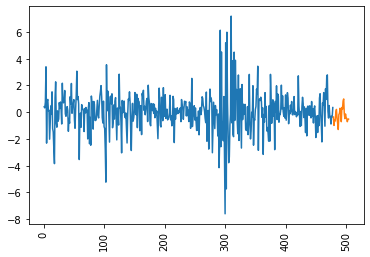

In [38]:
plt.plot(df_train_extended_VZ.index, df_train_extended_VZ.values)
plt.plot(diff_test_VZ[ - len(hybrid_prediction):].index, np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

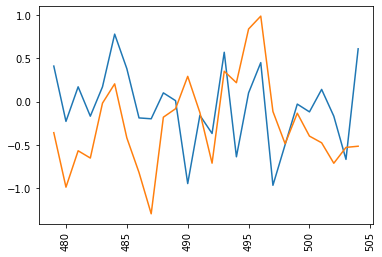

In [39]:
plt.plot(diff_test_VZ[ - len(hybrid_prediction):].index,
         diff_test_VZ[ - len(hybrid_prediction):])
plt.plot(diff_test_VZ[ - len(hybrid_prediction):].index,
         np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

In [40]:
hybrid_rmse = rmse(np.array(diff_test_VZ[ - len(hybrid_prediction):].values),
                   hybrid_prediction)
print('Hybrid RMSE is {:.4f}'.format(hybrid_rmse))

Hybrid RMSE is 0.6425
